In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
train_dir = '/kaggle/input/cats-and-dogs-image-classification/train'
test_dir = '/kaggle/input/cats-and-dogs-image-classification/test'

# Using ImageDataGenerator to load and augment images
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,  # Rotate images by 20 degrees
    width_shift_range=0.2,  # Shift images horizontally by 20%
    height_shift_range=0.2,  # Shift images vertically by 20%
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in on images
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels after transformation
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Only rescale test images

# Creating generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  # Increased resolution
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

Found 557 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


In [3]:
# Enhanced CNN model with more layers and regularization techniques
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout layer to reduce overfitting
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726047097.867630      83 service.cc:145] XLA service 0x78f8a80072a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726047097.867692      83 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726047097.867696      83 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/18 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5625 - loss: 1.5137 

I0000 00:00:1726047108.358480      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 947ms/step - accuracy: 0.5276 - loss: 1.5488 - val_accuracy: 0.5143 - val_loss: 1.0599 - learning_rate: 0.0010
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 235ms/step - accuracy: 0.5706 - loss: 0.9304 - val_accuracy: 0.5286 - val_loss: 2.2744 - learning_rate: 0.0010
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - accuracy: 0.6011 - loss: 0.8375 - val_accuracy: 0.5000 - val_loss: 3.6827 - learning_rate: 0.0010
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.5870 - loss: 0.8257 - val_accuracy: 0.5000 - val_loss: 5.1787 - learning_rate: 0.0010
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step - accuracy: 0.6332 - loss: 0.7408 - val_accuracy: 0.5000 - val_loss: 6.9998 - learning_rate: 2.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.6276 - loss: 0.7234 - val_accuracy: 0.5000 - val_loss: 7.3829 - learning_rate: 2.0000e-04


In [5]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.2%}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.5577 - loss: 1.0121
Test Accuracy: 51.43%


In [6]:
# Predict classes on the test set
y_pred = (model.predict(test_generator) > 0.5).astype(int)
y_true = test_generator.classes

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


In [7]:
# Confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[26 44]
 [38 32]]
              precision    recall  f1-score   support

           0       0.41      0.37      0.39        70
           1       0.42      0.46      0.44        70

    accuracy                           0.41       140
   macro avg       0.41      0.41      0.41       140
weighted avg       0.41      0.41      0.41       140



In [8]:
# Function to predict and visualize a result for a new image
def predict_and_visualize(image_path):
    img = cv2.imread(image_path)  # Read the image
    img_resized = cv2.resize(img, (128, 128)) / 255.0  # Resize and normalize
    prediction = model.predict(np.expand_dims(img_resized, axis=0))  # Make a prediction
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Display the image
    plt.title(f'Predicted: {"Dog" if prediction > 0.5 else "Cat"}')  # Show the prediction
    plt.axis('off')  # Remove axis
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


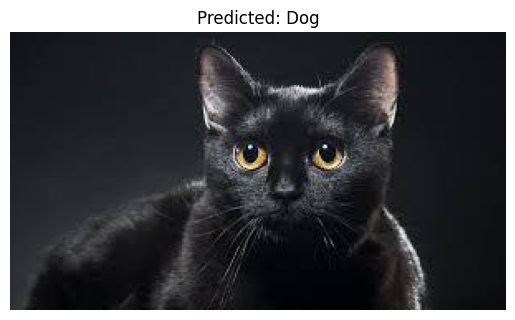

In [9]:
predict_and_visualize('/kaggle/input/cats-and-dogs-image-classification/train/cats/cat_101.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


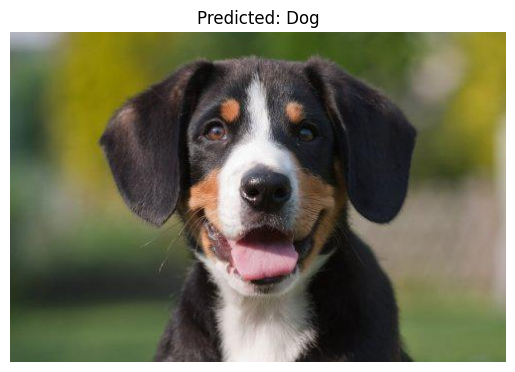

In [10]:
predict_and_visualize('/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_283.jpg')